In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers, activations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from math import sqrt
from scipy import stats
from datetime import datetime,timedelta

seed = 7
np.random.seed(seed)

from tensorflow.keras import backend
backend.set_floatx('float64')

## Carregando os Dados

In [2]:
def carregar_tabela(path):
    dataframe=pd.read_csv(path)
    dataset = dataframe.values
    X_train_all=dataframe[['Total amount of precipitation','Vapor_Pressure','Relative_Humudity','Amount of cloudiness','Actual_Pressure']]
    y_train_all=dataframe[['Temperature']]

    return X_train_all, y_train_all.values

In [3]:
filename = '2023Ogur/WeatherForcasting_DATA.csv'

X_train_all,y_train_all = carregar_tabela(filename)
#y_train_all = y_train_all.reshape(-1,1)

n_features = X_train_all.shape[1]
n_instances = X_train_all.shape[0]
print(f"There are {n_features} features and {n_instances} instâncias")
X_train_all.head()

There are 5 features and 43829 instâncias


,Total amount of precipitation,Vapor_Pressure,Relative_Humudity,Amount of cloudiness,Actual_Pressure
0,0.0,6.0,99,7,1020.2
1,0.0,5.6,99,7,1019.7
2,0.0,5.6,99,7,1019.4
3,0.0,5.6,94,7,1019.6
4,0.0,5.6,91,7,1019.6


In [4]:
y_train_all

array([[-0.7],
       [-1.3],
       [-1. ],
       ...,
       [15.3],
       [15.3],
       [15.3]])

## Normalizando

In [5]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train_all)
#scaler_y = StandardScaler()
#y_train_scaled = scaler_y.fit_transform(y_train_all)

In [6]:
y_train_all

array([[-0.7],
       [-1.3],
       [-1. ],
       ...,
       [15.3],
       [15.3],
       [15.3]])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_all, test_size=0.9, random_state=42)
X_train = tf.cast(X_train, dtype=tf.float64)
y_train = tf.cast(y_train, dtype=tf.float64)
print("Len(Train):",len(X_train))
print("Len(Test):",len(X_val))

Len(Train): 4382
Len(Test): 39447


## Rede Quântica

In [8]:
def H_layer(n_qubits):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def Data_AngleEmbedding_layer(inputs, n_qubits):
    qml.templates.AngleEmbedding(inputs,rotation='Y', wires=range(n_qubits))

def RY_layer(w):
    print(w.shape)
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def ROT_layer(w):
    for i in range(5):
        qml.Rot(*w[i],wires=i)

def strong_entangling_layer(nqubits):
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[3,4])
    qml.CNOT(wires=[4,0])
    
    
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

In [9]:
n_qubits = n_features
print(f"Serão necessários {n_qubits} qubits")
n_layers = 1

#dev = qml.device('lightning.gpu', wires=n_qubits)
#dev = qml.device('lightning.qubit', wires=n_qubits)
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface="torch")
def qnode(inputs, weights_1):
    H_layer(n_qubits)
    Data_AngleEmbedding_layer(inputs, n_qubits)
    for k in range(n_layers):
        entangling_layer(n_qubits)
        ROT_layer(weights_1[k])
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

Serão necessários 5 qubits


## Drawing Quantum Circuit

In [10]:
weight_shapes = {"weights_1": (n_layers,n_qubits,3)}

sampl_weights = np.random.uniform(low=0, high=np.pi, size=weight_shapes["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(n_qubits,))
print(qml.draw(qnode, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(2.86)─╭●──Rot(0.24,2.45,1.38)──────────────────────┤  <Z>
1: ──H──RY(0.67)─╰X─╭●────────────────────Rot(2.27,3.07,1.69)─┤  <Z>
2: ──H──RY(1.42)─╭●─╰X────────────────────Rot(1.57,0.23,0.84)─┤  <Z>
3: ──H──RY(2.93)─╰X─╭●────────────────────Rot(1.57,2.13,2.53)─┤  <Z>
4: ──H──RY(0.08)────╰X────────────────────Rot(1.20,0.21,0.91)─┤  <Z>


In [11]:
q_layer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
Activation=tf.keras.layers.Activation(activations.linear)
output_layer = tf.keras.layers.Dense(1,kernel_initializer='normal')

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

model = tf.keras.models.Sequential([q_layer,Activation, output_layer])
model.compile(opt, loss="mse")

In [12]:
input_shape = (n_qubits,)

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (5, 5)                    15        
                                                                 
 activation (Activation)     (5, 5)                    0         
                                                                 
 dense (Dense)               (5, 1)                    6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [13]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train, epochs=30, batch_size=64, callbacks=[re], verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
69/69 [==============================] - 28s 403ms/step - loss: 116.6357 - val_loss: 53.8546 - lr: 0.1000
Epoch 2/30
69/69 [==============================] - 27s 396ms/step - loss: 49.0840 - val_loss: 45.6075 - lr: 0.1000
Epoch 3/30
69/69 [==============================] - 27s 396ms/step - loss: 44.3763 - val_loss: 42.3966 - lr: 0.1000
Epoch 4/30
69/69 [==============================] - 27s 402ms/step - loss: 41.6402 - val_loss: 40.2328 - lr: 0.1000
Epoch 5/30
69/69 [==============================] - 27s 401ms/step - loss: 39.8275 - val_loss: 39.3059 - lr: 0.1000
Epoch 6/30
69/69 [==============================] - 27s 401ms/step - loss: 38.7552 - val_loss: 37.5990 - lr: 0.1000
Epoch 7/30
69/69 [==============================] - 27s 402ms/step - loss: 37.9179 - val_loss: 37.0712 - lr: 0.1000
Epoch 8/30
69/69 [==============================] - 28s 404ms/step - loss: 37.3710 - val_loss: 36.5604 - lr: 0.1000
Epoch 9/30
69/69 [==============================] - 27s 401ms/step - lo

## Criando gráfico de Loss por Epoch

In [14]:
def plot_history(history):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title("Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.legend()
    plt.show()

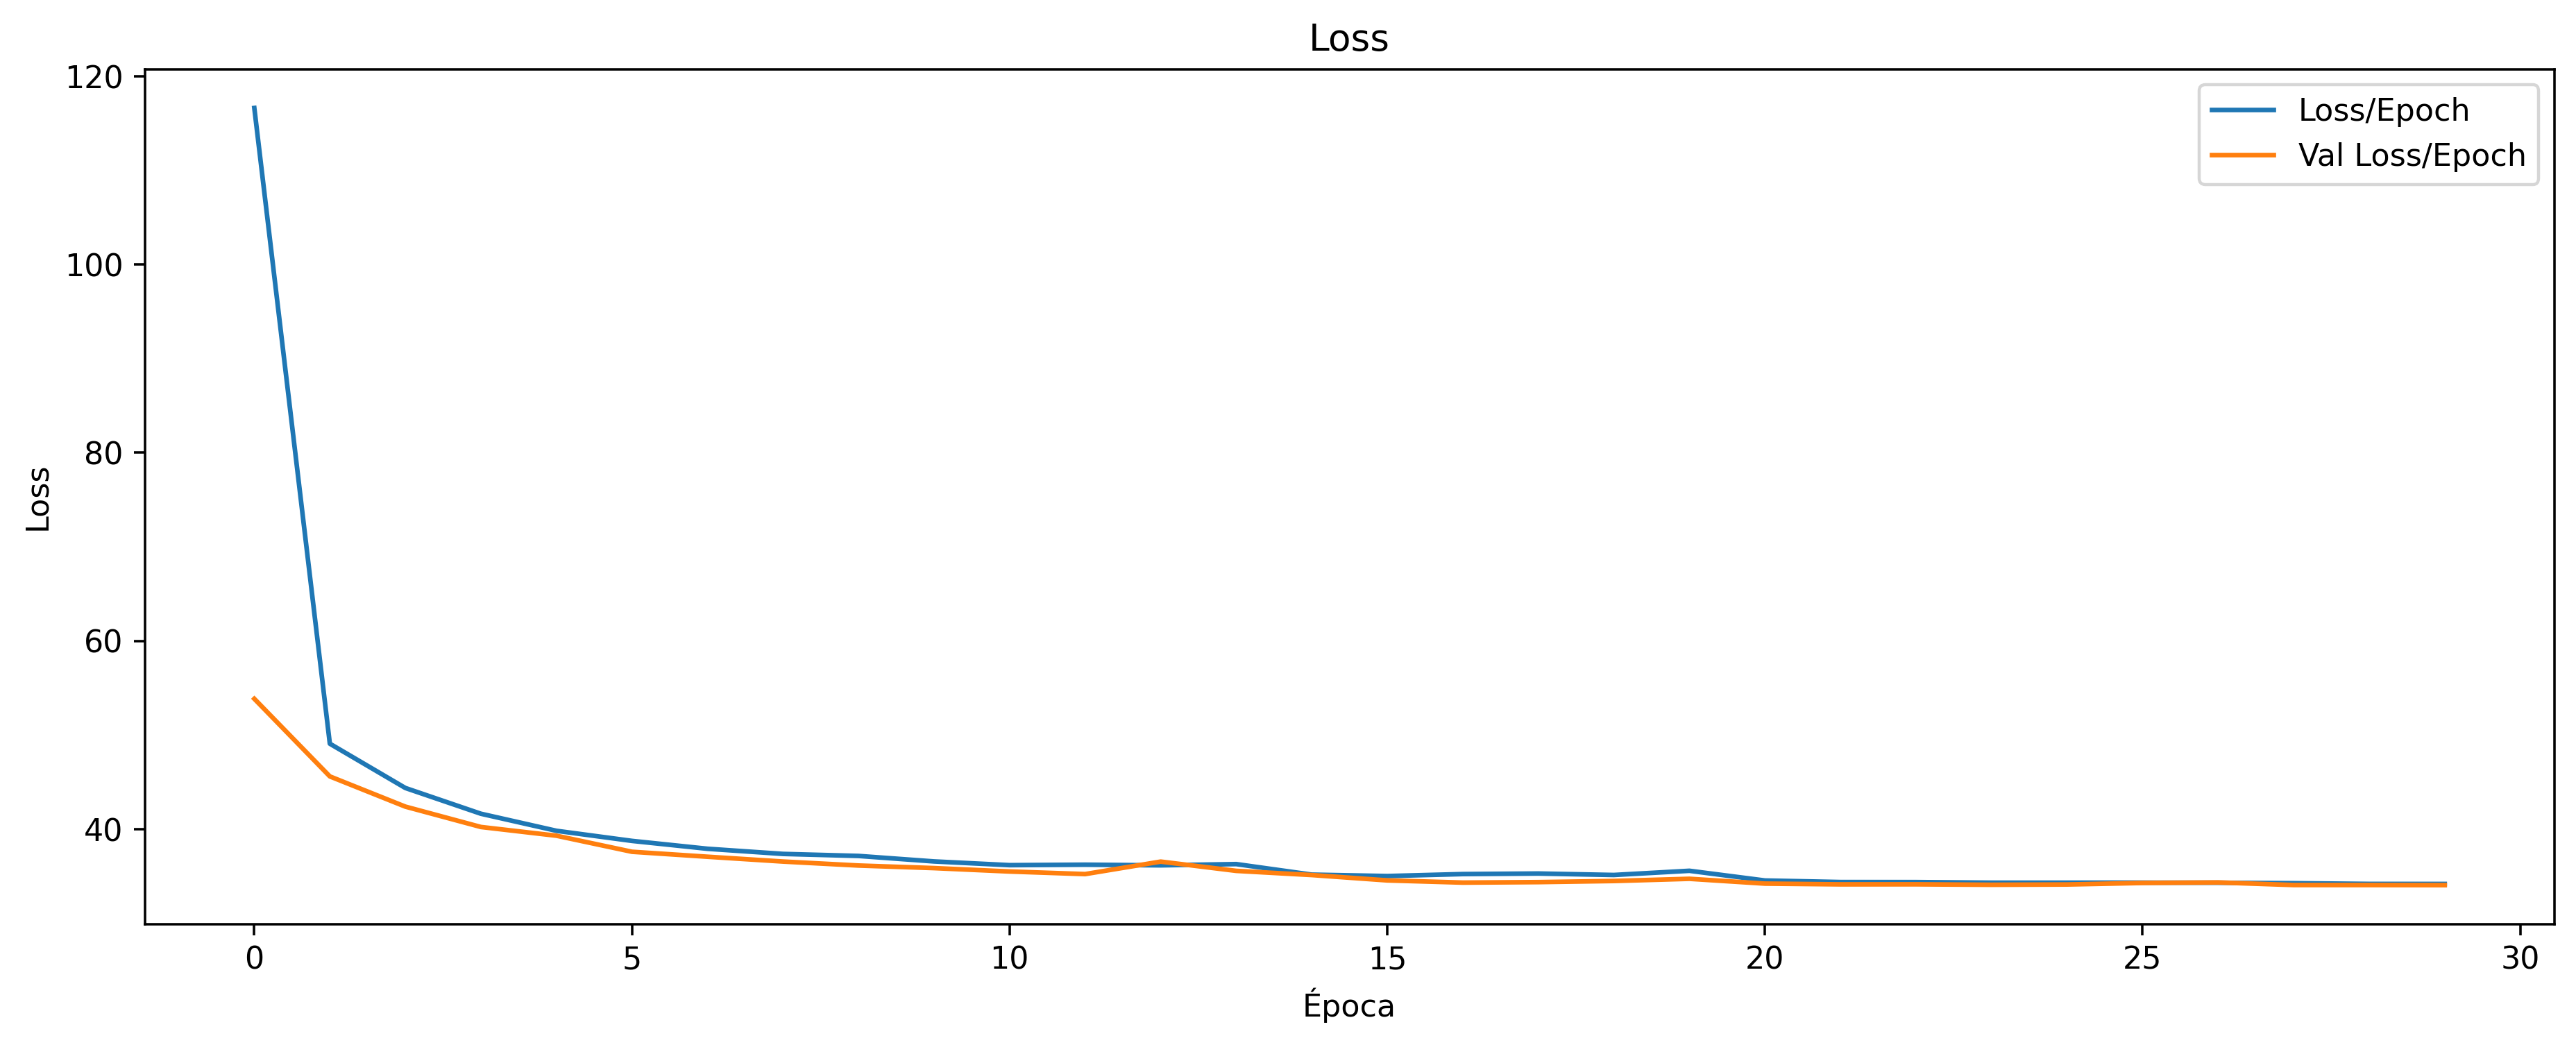

In [15]:
plot_history(history_model)

## Validação

In [28]:
y_predict=model.predict(X_val,verbose=1)
#predict_normal = scaler_y.inverse_transform(predict)
y_predict

1233/1233 [==============================] - 43s 35ms/step


array([[20.39457927],
       [14.42594787],
       [17.8125463 ],
       ...,
       [16.97062729],
       [18.80773369],
       [12.36212374]])

In [35]:
print('Mean Squared Error:', mean_squared_error(y_val, y_predict))

Mean Squared Error: 34.05348720546976


In [40]:
def factor_of_2(y_true, y_pred):
    min_ = 0.5
    max_ = 2.0

    tensor_true = tf.constant(y_true)
    tensor_true = tf.cast(tensor_true, tf.float32)
    tensor_pred = tf.constant(y_pred)
    tensor_pred = tf.cast(tensor_pred, tf.float32)

    division = tf.divide(tensor_pred, tensor_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    return backend.get_value(tf.reduce_mean(res))


def allmetrics(original,predito):
    r_value = 0
    slope, intercept, r_value, p_value, std_err = stats.linregress(original, predito)
    mse = mean_squared_error(original, predito)
    mae = mean_absolute_error(original, predito)
    rr = r2_score(original,predito)
    pea = stats.pearsonr(original, predito)
    fat = factor_of_2(original,predito)
    nmse = mse/stats.tvar(original)
    rmse = sqrt(mse)
    nrmse = rmse/stats.tstd(original)
    return mae,mse,nmse,r_value,rr,fat,rmse,nrmse

In [41]:
def get_error_interval(model, X_val, Y_val, y_test_pred, p_value):
    y_val_pred = model.predict(X_val)
    y_val_error = np.abs(Y_val - y_val_pred)
    error_quantile=np.ndarray((1,Y_val.shape[1]));
    for i in range(Y_val.shape[1]):
        error_quantile[0,i] = np.quantile(y_val_error[:,i], q=p_value, interpolation='higher')
        
    y_test_interval_pred_left=np.ndarray(y_test_pred.shape);
    y_test_interval_pred_right=np.ndarray(y_test_pred.shape);
    
    for i in range(y_test_pred.shape[1]):
        y_test_interval_pred_left[:,i] = y_test_pred[:,i] - error_quantile[0,i]
        y_test_interval_pred_right[:,i] = y_test_pred[:,i] + error_quantile[0,i]
    return error_quantile, y_test_interval_pred_left, y_test_interval_pred_right

In [42]:
def get_mean_left_right_error_interval(model, y_test, y_scaler, y_test_pred):
    error, error_left, error_right = get_error_interval(model, X_val, y_val, y_test_pred, 0.95)
    
    #error_left_normal = y_scaler.inverse_transform(error_left)
    #error_right_normal = y_scaler.inverse_transform(error_right)

    error_left_normal = error_left
    error_right_normal = error_right

    mean_error_normal=np.ndarray((1,y_test.shape[1]));
    mean_error_left_normal=np.ndarray((1,y_test.shape[1]));
    mean_error_right_normal=np.ndarray((1,y_test.shape[1]));
    mean_predictions=np.ndarray((1,y_test_pred.shape[1]));

    for i in range(y_test.shape[1]):
        mean_error_left_normal[0,i] = np.mean(error_left_normal[:,i])
        mean_error_right_normal[0,i] = np.mean(error_right_normal[:,i])
        mean_predictions[0,i]=np.mean(y_test_pred[:,i])

    mean_error_normal=(mean_error_right_normal-mean_error_left_normal)/2
    return mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal

In [43]:
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(
    model, y_val, scaler_x, y_predict)

/tmp/ipykernel_34161/2628266574.py:2: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  error, error_left, error_right = get_error_interval(model, X_val, y_val, y_test_pred, 0.95)


In [50]:
def get_plot_prediction_versus_observed(model, y_test, predict):
    valores = []
    for i in range(y_test.shape[1]):
        mae,mse,nmse,r_value,rr,fat,rmse,nrmse = allmetrics(y_test[:,i],predict[:,i])
        valores.append([str(i+1)+" depth",mae,mse,nmse,rmse,nrmse,r_value,rr,fat,mean_error_normal[0,i],mean_error_left_normal[0,i],mean_predictions[0,i],mean_error_right_normal[0,i]])
        print("MAE:",mae)
        print("MSE:",mse)
        print("NMSE:",nmse)
        print("RMSE:",rmse)
        print("NRMSE:",nrmse)
        print("R:",r_value)
        print("R²:",rr)
        print("Fator de 2:",fat)

    erros = pd.DataFrame(valores)
    erros.columns = ['Index','MAE','MSE','NMSE','RMSE','NRMSE','R','R²','Fator de 2', 'error interval (+/-)', 'left limit', 'mean', 'right limit']
    erros = erros.set_index('Index')
    erros.loc['Média'] = erros.mean()
    return erros


In [51]:
erros_pd=get_plot_prediction_versus_observed(model, y_val, y_predict)
erros_pd

MAE: 4.54164377656887
MSE: 34.05348720546976
NMSE: 0.5880247067511108
RMSE: 5.835536582480634
NRMSE: 0.7668276903914665
R: 0.6446420961272682
R²: 0.4119603861681522
Fator de 2: 0.83950615


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2,error interval (+/-),left limit,mean,right limit
Index,,,,,,,,,,,,
1 depth,4.541644,34.053487,0.588025,5.835537,0.766828,0.644642,0.41196,0.839506,10.786138,4.592313,15.378451,26.164589
Média,4.541644,34.053487,0.588025,5.835537,0.766828,0.644642,0.41196,0.839506,10.786138,4.592313,15.378451,26.164589
